<a href="https://colab.research.google.com/github/claree007/Predict-Cristiano-Ronaldo-s-Goal/blob/master/Cristiano_Ronaldo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Score!</h1>

In [0]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve

<h2>Load the data</h2>

In [9]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1.0,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,2.0,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,3.0,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,4.0,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,5.0,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


<h2>Create train and test set</h2>

In [10]:
# all rows with 'is_goal' as NaN are test data and rest are training data
train_set = data.loc[data['is_goal'].notnull()]
test_set = data.loc[data['is_goal'].isna()]

print("Train set size:", len(train_set))
print("Test set size:", len(test_set))

Train set size: 24429
Test set size: 6268


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 28 columns):
Unnamed: 0               30697 non-null int64
match_event_id           29134 non-null float64
location_x               29236 non-null float64
location_y               29157 non-null float64
remaining_min            29135 non-null float64
power_of_shot            29211 non-null float64
knockout_match           29180 non-null float64
game_season              24835 non-null object
remaining_sec            29103 non-null float64
distance_of_shot         29130 non-null float64
is_goal                  24429 non-null float64
area_of_shot             29195 non-null object
shot_basics              29122 non-null object
range_of_shot            29133 non-null object
team_name                29162 non-null object
date_of_game             29147 non-null object
home/away                29200 non-null object
shot_id_number           29134 non-null float64
lat/lng                  29132 non-n

All the numeric features look good since the features which appear so, are already in numeric data type. But some of other features are categorical data but theie data type is different. So we need to change them to categorical data.

<h2>Data Preprocessing</h2>

In [0]:
class ChangeToCategory(BaseEstimator, TransformerMixin):
    def __init__(self, labels):
        self.labels = labels
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col in self.labels:
            X[col] = X[col].astype('category')
        return X

num_attr = ['location_x', 'location_y', 'remaining_min', 'remaining_sec', 
            'distance_of_shot', 'remaining_min.1', 'knockout_match.1', 
            'remaining_sec.1', 'distance_of_shot.1']
cat_attr = ['power_of_shot', 'area_of_shot', 'shot_basics', 'range_of_shot', 
            'type_of_shot', 'type_of_combined_shot']
label = ['is_goal']
all_attr = num_attr + cat_attr

# pipeline for numerical attributes
num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

# pipeline for categorical attributes
cat_pipeline = Pipeline([
    ('to_catergory', ChangeToCategory(cat_attr)),
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('ordinal', OrdinalEncoder()),
])

final_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', cat_pipeline, cat_attr),
])

X_train = final_pipeline.fit_transform(train_set)
y_train = train_set['is_goal'].values

<h2>Data Visualization</h2>

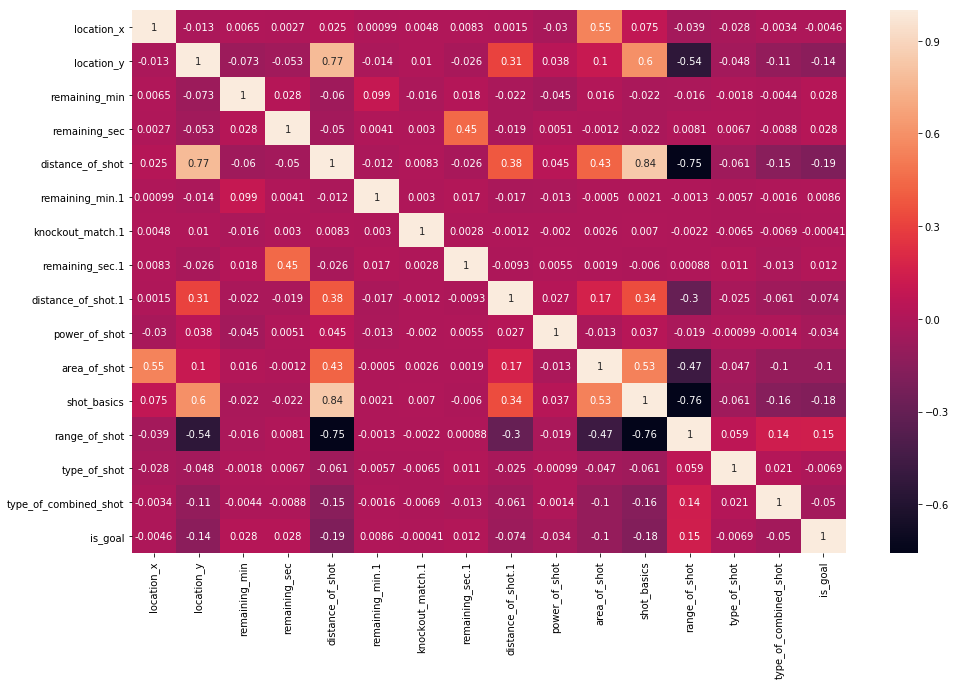

In [13]:
correlation = pd.DataFrame(
    np.append(X_train, train_set['is_goal'].values.reshape((-1, 1)), axis=1),
    columns=all_attr+['is_goal']
    ).corr()
fig = plt.figure(figsize=(16, 10))
fig = sns.heatmap(correlation, annot=True)

**Number of attempts and goals**

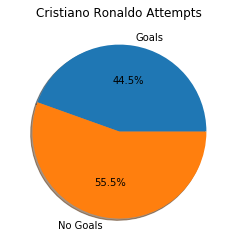

In [14]:
goals = len(train_set.loc[train_set['is_goal'] == 1.0])
no_goals = len(train_set) - goals

plt.pie([goals, no_goals], labels=['Goals', 'No Goals'], autopct='%1.1f%%', shadow=True)
plt.title("Cristiano Ronaldo Attempts")
plt.show()

Looking at the above pie chart we can conclude that truly Ronaldo is a great player as he has scored a goal 44.5% of the time which is about **every second attempt results in goal**.

**Distribution of goals scored during the match**

No. of goals scored within first 5 minutes: 755
No. of goals scored within last 5 minutes: 3956


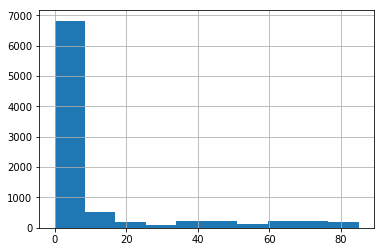

In [15]:
scored_within_5_min = train_set.loc[(train_set['remaining_min.1'] >= 85.0) & (train_set['is_goal'] == 1.0)]
scored_last_5_min = train_set.loc[(train_set['remaining_min.1'] < 5.0) & (train_set['is_goal'] == 1.0)]

print("No. of goals scored within first 5 minutes:", len(scored_within_5_min))
print("No. of goals scored within last 5 minutes:", len(scored_last_5_min))

goal_data = train_set.loc[train_set['is_goal'] == 1.0]
bins = np.arange(0.0, 95.0, 5.0)
score_interval = pd.cut(goal_data['remaining_min.1'], bins=bins, labels=bins[:-1])
score_interval.hist()

Here the bar graph and the calculation do not match for the goals scored. If you can figure out why please expain this to me.

<h2>Training</h2>

I am running this notebook in google colab, and many times it stops working so I have only listed the best hyperparameters in predicting the correct label. So you will see only one value in the parameter grid for the models. 

Implementing grid search

In [0]:
def grid_search_cv(model, param_grid={}):
    grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1,
                               scoring='accuracy',
                               return_train_score=True, error_score=0.0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            grid_search.fit(X_train, y_train)
        except:
            pass
    try:
        feature_importances = grid_search.best_estimator_.feature_importances_
        imp = sorted(zip(feature_importances, all_attr), reverse=True)
        imp = pd.DataFrame(imp, columns=['Importance', 'Feature'])
        print(imp)
    except:
        pass
    print("Accuracy:", grid_search.best_score_)
    return grid_search.best_estimator_

SVM

In [20]:
svc = SVC()

param_grid = {'C': [0.8], 'kernel': ['rbf'], 'degree': [2], 'gamma': [5],
              'coef0': [0.8], 'max_iter': [6000], 'probability': [True]}

svc = grid_search_cv(svc, param_grid)

Accuracy: 0.5622415981006181


Random Forest Classifier

In [18]:
rf_clf = RandomForestClassifier()

param_grid = {'n_estimators': [100], 'criterion': ['gini'], 'min_samples_split': [4],
              'min_samples_leaf': [4], 'bootstrap': [True], 'n_jobs': [-1],
              'warm_start': [False]}

rf_clf = grid_search_cv(rf_clf, param_grid)

    Importance                Feature
0     0.110515             location_y
1     0.109252        remaining_sec.1
2     0.106109             location_x
3     0.103403          remaining_sec
4     0.090172           type_of_shot
5     0.082661     distance_of_shot.1
6     0.082207        remaining_min.1
7     0.071727       distance_of_shot
8     0.064883          remaining_min
9     0.045467       knockout_match.1
10    0.041224          power_of_shot
11    0.028395  type_of_combined_shot
12    0.024617            shot_basics
13    0.020874           area_of_shot
14    0.018494          range_of_shot
Accuracy: 0.6137377706823857


Saving probabilities for all the models

In [0]:
# preparing the test set
X_test = final_pipeline.transform(test_set)

# saving the probability of scoring a goal
y_proba_rf = rf_clf.predict_proba(X_test)
y_proba_svm = svc.predict_proba(X_test)

<h2>Model Evaluation</h2>

In [0]:
def precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def yscores(model, X, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            return cross_val_predict(model, X, y, cv=3, method="decision_function")
        except:
            y_probas = cross_val_predict(model, X, y, cv=3, method="predict_proba")
            return (y_probas[:, 1] >= 0.4)*1
    print("None worked!!")
    return None
    
def plot_roc_curve(fpr_s, tpr_s, labels=None):
    for fpr, tpr, label in zip(fpr_s, tpr_s, labels):
        plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC curve")
    plt.legend()
    plt.show()

**Precision vs Recall Curve**

RandomForestClassifier


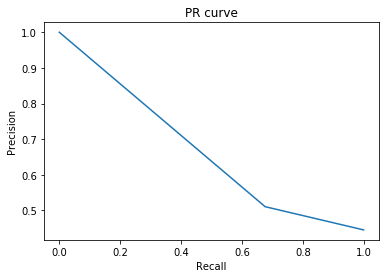





SVC


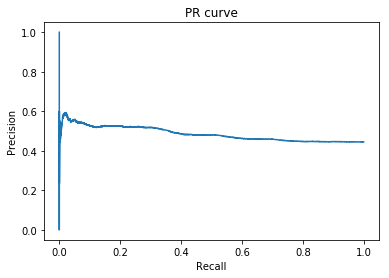

In [23]:
fpr_s = []
tpr_s = []
y_scores = []
model_precisions = []
model_recalls = []
model_thresholds = []
best_models = [rf_clf, svc]
model_names = [type(model).__name__ for model in best_models]

# plotting different curves
for model in best_models:
    print(type(model).__name__)
    y_score = yscores(model, X_train, y_train)
    y_scores.append(y_score)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)
    model_precisions.append(precisions)
    model_recalls.append(recalls)
    model_thresholds.append(thresholds)
    precision_vs_recall(precisions, recalls)
    fpr, tpr, _ = roc_curve(y_train, y_score)
    fpr_s.append(fpr)
    tpr_s.append(tpr)
    print('\n\n\n')

**ROC Curve**

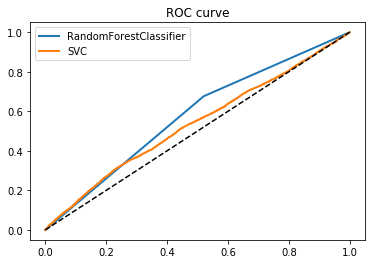

In [24]:
plot_roc_curve(fpr_s, tpr_s, model_names)

<h2>Conclusion</h2>

**Random Forest Classifier** performs better than SVM classifier and so it is my choice of model. This is shown by the accuracy and ROC curve comparison.

**Saving to file**

In [25]:
# keeping probabilities of random forest classifier
y_proba = y_proba_rf

# saving columns and probabilities
shot_id_number = test_set['shot_id_number'].values
answer = pd.DataFrame(list(zip(shot_id_number, y_proba[:, 1])),
                      columns=['shot_id_number', 'is_goal'])
answer.to_csv("prediction.csv", index=False)
print("Saved to file")

Saved to file
